<a href="https://colab.research.google.com/github/awaaat/Machine_learning-Deep_learning/blob/main/Best_Sentiment_Analysis_Test_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


#Download and explore the IMDB dataset

In [154]:
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file(
    'aclImdb',
    dataset_url,
    untar = True,
    cache_dir= '.',
    cache_subdir = ""
)

In [155]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['imdbEr.txt', 'README', 'train', 'test', 'imdb.vocab']

Explore our dataset

In [156]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt',
 'urls_pos.txt']

In [157]:
#Let us open a sample file
sample_file = os.path.join(train_dir, '/content/aclImdb/train/pos/10000_8.txt')
with open(sample_file) as f:
  print(f.read())

Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days without th

#Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful text_dataset_from_directory utility, which expects a directory structure as follows.
To prepare a dataset for binary classification, you will need two folders on disk, corresponding to class_a and class_b. These will be the positive and negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [158]:
os.listdir(train_dir)

['neg',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt',
 'urls_pos.txt']

In [159]:
#remove_dir = os.path.join(train_dir, 'unsup')
#shutil.rmtree(remove_dir)

In [160]:
os.listdir(train_dir)

['neg',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt',
 'urls_pos.txt']

In [161]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size = 32,
    seed = 42,
    shuffle = True,
    subset = 'training',
    validation_split = 0.2
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [162]:
#check a few of the sample dataset
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print(f"Text Review: {text_batch.numpy()[i]}")
    print(f"Label: {label_batch.numpy()[i]}")

Text Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: 0
Text Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as t

In [163]:
print(raw_train_ds.class_names[1])
print(raw_train_ds.class_names[0])

pos
neg


In [164]:
#Create a validation dataset
raw_val_set = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size = 32,
    seed = 42,
    shuffle = True,
    subset = 'validation',
    validation_split = 0.2
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [165]:
#Create test set
raw_test_set = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = 32
)

Found 25000 files belonging to 2 classes.


Prepare the dataset for training
Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [166]:
def custom_standardizer(text_input):
    # Convert text to lowercase using tf.strings.lower
    lowercase = tf.strings.lower(text_input)

    # Replace '<br />' with a space using tf.strings.regex_replace
    stripped_text = tf.strings.regex_replace(lowercase, '<br />', " ")

    # Remove punctuation using tf.strings.regex_replace
    return tf.strings.regex_replace(stripped_text,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')


In [167]:
max_deatures = 10000
sequence_length = 250
vectorize_layer = layers.TextVectorization(
    max_tokens = 10000,
    standardize = custom_standardizer,
    output_mode = 'int',
    output_sequence_length = sequence_length

)

#Let us then Make a text-only dataset (without labels), then call adapt

In [168]:
train_text = raw_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(train_text)

In [169]:
#Let us view sample texts
def vectorized_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [170]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(f"Review: {first_review}")
print(f"label: {raw_train_ds.class_names[first_label]}")
print(f"Vectorized Text: {vectorized_text(first_review, first_label)}")

Review: b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a

In [171]:
print(vectorize_layer.get_vocabulary()[3209])

shoots


We   will now apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [172]:
train_set = raw_train_ds.map(vectorized_text)
test_set = raw_test_set.map(vectorized_text)
validation_set = raw_val_set.map(vectorized_text)


Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [173]:
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

We Now go to the Juicy part........
##Create the model
It's time to create your neural network:

In [174]:
embedding_dim = 16
# Create a Sequential model
model = tf.keras.Sequential([
    # Embedding layer to convert integer indices into dense vectors of fixed size
    layers.Embedding(max_deatures, embedding_dim),
    # Dropout layer to reduce overfitting by randomly setting a fraction of input units to 0
    layers.Dropout(0.2),
    # GlobalAveragePooling1D layer to reduce the dimensionality of the data by averaging over the time dimension
    layers.GlobalAveragePooling1D(),
    # Another Dropout layer for regularization
    layers.Dropout(0.2),
    # Dense layer with a single unit and sigmoid activation function for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Print the summary of the model to see the architecture and parameters
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

Now, configure the model to use an optimizer and a loss function:

In [194]:
model.compile(
  loss = losses.BinaryCrossentropy(),
  optimizer = 'adam',
  metrics = [tf.metrics.BinaryAccuracy(threshold=0.5)]
)

#We Now Train our Model

In [176]:
epochs = 10
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs = epochs,

)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - binary_accuracy: 0.5797 - loss: 0.6810 - val_binary_accuracy: 0.7414 - val_loss: 0.6077
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.7632 - loss: 0.5735 - val_binary_accuracy: 0.8104 - val_loss: 0.4936
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - binary_accuracy: 0.8243 - loss: 0.4620 - val_binary_accuracy: 0.8310 - val_loss: 0.4251
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - binary_accuracy: 0.8509 - loss: 0.3913 - val_binary_accuracy: 0.8362 - val_loss: 0.3876
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - binary_accuracy: 0.8671 - loss: 0.3467 - val_binary_accuracy: 0.8518 - val_loss: 0.3563
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8812 - loss: 0.3136 - val_binary_accuracy: 0.8536 - val_loss: 0.3425
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8932 - loss: 0.2880 - val_binary_accuracy: 0.8528 - val_loss: 0.3342
Epoch

#Model Evaluation

In [177]:
loss, accuracy = model.evaluate(test_set)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - binary_accuracy: 0.8550 - loss: 0.3316
Loss: 0.3332412540912628
Accuracy: 0.8546800017356873


Create a plot of accuracy and loss over time

In [178]:
history_dict= history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

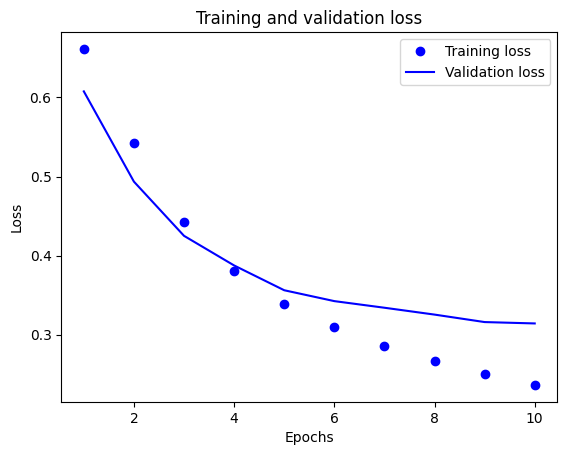

In [179]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) +1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

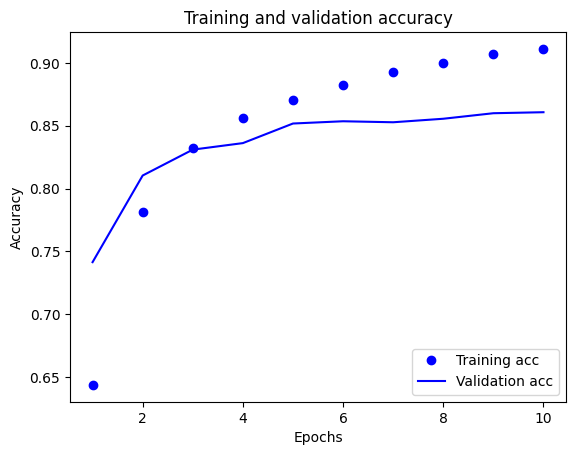

In [180]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

#We can Export Our Model

In [181]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,  # This should be your main model, e.g., an embedding and dense layers
    layers.Activation('sigmoid')  # Optional if already handled by BinaryCrossentropy
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=['accuracy']
)
print(accuracy)

0.8546800017356873


In [182]:
# Evaluate the model with preprocessed test data
accuracy = export_model.evaluate(raw_test_set)  # raw_test_set should be in the form of (text, label)
print("Accuracy:", accuracy)


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5017 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
Accuracy: [0.0, 0.0, 0.0, 0.5000399947166443]


#Inference on new data, we can simply call model.predict().

In [215]:
Wed_review = tf.constant([
"The movie was worse",
"the best and sweet",
"The movie was nice...",
"This was the awesome best I ever watched",
"The stupid stuff never watching it again",
 ])


In [216]:
def predict_and_debug(model, text_reviews, threshold=0.5):
    # Directly pass the string to the model
    model = export_model
    predicted_probs = model(text_reviews)

    for i, prob in enumerate(predicted_probs):
        print(f"Review: {text_reviews[i].numpy().decode('utf-8')}")
        print(f"Predicted Probability: {prob[0]}")

        # Determine the review label based on the probability and the threshold
        if prob[0] >= threshold:
            review_label = "Positive Review"
            print("Classified as: Positive Review")
        else:
            review_label = "Negative Review"
            print("Classified as: Negative Review")

        print()

predict_and_debug(export_model, Wed_review, threshold=0.56)


Review: The movie was worse
Predicted Probability: 0.5324661135673523
Classified as: Negative Review

Review: the best and sweet
Predicted Probability: 0.5935217142105103
Classified as: Positive Review

Review: The movie was nice...
Predicted Probability: 0.5613322854042053
Classified as: Positive Review

Review: This was the awesome best I ever watched
Predicted Probability: 0.592423677444458
Classified as: Positive Review

Review: The stupid stuff never watching it again
Predicted Probability: 0.5396130681037903
Classified as: Negative Review



In [222]:
#Let us create a simple classification from user input...... Awesome thing

def get_movie_review_input():
    # Get movie name and review from the user
    movie_name = input("Enter the movie name: ")
    review = input("Enter your review: ")
    return movie_name, review

def classify_review(model, review, threshold=0.5):
    # Convert the review to a tensor
    review_tensor = tf.constant([review])
    model = export_model
    # Get the predicted probability from the model
    predicted_prob = model(review_tensor)[0][0].numpy()

    # Determine if the review is positive or negative based on the threshold
    is_positive = predicted_prob >= threshold
    return is_positive

def main():
    # Get user input
    movie_name, review = get_movie_review_input()

    # Classify the review
    is_positive = classify_review(export_model, review, threshold=0.56)

    # Print the result
    if is_positive:
        print(f"The movie '{movie_name}' is positively reviewed, mostly.")
    else:
        print(f"The movie '{movie_name}' is negatively reviewed, mostly.")

# Run the main function to execute the pipeline
main()


Enter the movie name: wed
Enter your review: the worst
The movie 'wed' is negatively reviewed, mostly.
